## MOU

## Estimation
### Moments
### MMSE
### MLE
### Bayesian

## Multivariate Ornstein-Uhlenbeck

Dynamics of each node i in the network:
$ \frac{dx_i}{dt} = -\frac{x_i}{\tau_x} + \sum_{j\ne i}^M C_{ij} x_j + \mu_i + \sigma_i \frac{dB_i}{dt} $

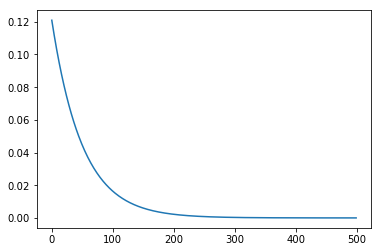

In [97]:
from MOU import MOU
from scipy.io import loadmat
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

model = MOU(n_nodes=1, tau_x=50, mu=0.0, Sigma=1e-18)
#model.C[0, 1] = 0.02
#model.C[1, 0] = 0.02
ts = model.simulate(T=500)
plt.figure()
plt.plot(ts)
plt.show()

### Forward step
The Jacobian of the system is: $ J_{ij} = -\frac{\delta_{ij}}{\tau_x}C_{ij}$, where $\delta_{ij}$ is Kronecker's delta.
Deriving the covariance of the system we obtain the Lyapunov equation: $ JQ^0 + Q^0J^T + \Sigma = 0 $, where $\Sigma$ is the diagonal matrix $\Sigma_{ii} = \sigma_i$.
From this equation the vectorized covariance can be calculated as: 
$$ vec(Q^0) = -\frac{vec(\Sigma)}{I_M \otimes J + \tilde{J} \otimes I_M}$$
where $\tilde{A}$ indicates the matrix of complex conjugate elements of $A$.
Similarly the derivation of the time-lagged covariance for lag $\tau$ yealds:
$$ Q^{\tau} = Q^0 expm(J^T\tau)$$

These equations allow to compute the farward step: calculate (time-lagged) covariance matrix knowing the parameters of the system $\theta: \{C, \Sigma, \tau_x\}$.

### Parameter estimation
#### Moments method
In order to estimate the parameters $\theta$ we can apply the moments method.
We can use the empirical covariances $\hat{Q}^0$, $\hat{Q}^{\tau}$ and last equation to get:
$$ \hat{J} = \frac{1}{\tau} \Bigl[logm(\hat{Q}^{\tau}(\hat{Q}^0)^{-1})\Bigr]^{T}  $$
An estimate of $\Sigma$ can then be calculated from Lyapunov equation above:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

#### Natural Gradient Optimization:
Lyapunov function:
$$ V(C) = (Q^0-\hat{Q}^0)^2 + (Q^{\tau}-\hat{Q}^{\tau})^2 $$
$$ \Delta J = \frac{1}{\tau} \Bigl[(Q^0)^{-1} (\Delta Q^0 + \Delta Q^{\tau} expm(-J^T \tau)) \Bigr]^T$$
$$\Delta \Sigma_{ii} = \hat{Q}^0_{ii} - Q^0_{ii}$$

#### Bayesian approach
The probability of the state of the system at time $t'$ give its state at time $t$ is given by:
$$ x(t'|t) \sim \mathcal{N}\Bigl(expm(J\Delta t)x(t), \Xi \Bigr)$$
where $\Xi = Q^0 - expm(J\Delta t) Q^0 expm(J \Delta t)^T$ and $\Delta t = t'-t$.

The stationary distribution is: $x \sim \mathcal{N}(0, Q^0)$.

Given a dataset where x is sampled at regular intervals $x^1, x^2,\dots, x^N$, and $X$ is the $M$ times $N$ matrix collecting all the $N$ observations for each of the $M$ nodes, the likelihood function is given by:
$$p(X|\theta) = \prod_n^N p(x^{n+1} | x^n, \theta)p(x^1|\theta)$$
Then the posterior distribution of parameters is given by:
$$ p(\theta|X)=\frac{p(X|\theta)p(\theta)}{p(X)}$$
The log posterior substituting the explicit pdfs is:
$$ ln p(\theta|X) = -\frac{1}{2} \sum_n^N \Delta_n^T \Xi \Delta_n -\frac{1}{2} (x^1)^T (Q^0)^{-1} x^1 + \frac{N-1}{2} ln \frac{1}{(2\pi)^M |\Xi|} + \frac{1}{2} ln \frac{1}{(2\pi)^M |Q^0|} $$
where $\Delta_n = x^{n+1}+Jx^n$.
Taking the derivative of the log posterior and maximizing yields the MAP solution. Defining $T^0 = \sum^N x^n(x^n)^T $ and $T^1 = \sum^N x^{n+1}(x^n)^T $, the MAP solution for $\Lambda=exmp(J \Delta t)$ is:
$\hat{\Lambda} = T^1 (T^0)^{-1}$ ($\Xi$ can also be estimated with the same method).
It follows than that:
$$ \hat{J} = \frac{logm(\hat{\Lambda})}{\Delta t} $$
Sigma can then be estimated again from the Lyapunov equation:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

(0.45855504246577616, 0.0)


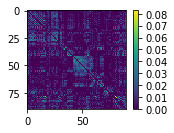

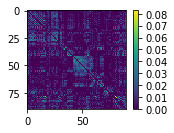

In [106]:
from MOU import MOU
from scipy.io import loadmat
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

data = loadmat('/home/andrea/Work/data/AD_compact/data/alzheimers_3rd_TS.mat')
TS = data['TS']
subj = 3
ts = TS[:, :, subj].T
model = MOU(n_nodes=90)
model.fit(X=ts)
C_true = model.C
ts_sim = model.simulate(T=1000)
model.fit(X=ts_sim, method='lyapunov')
Clya = model.C
model.fit(X=ts_sim, method='moments')
Cmom = model.C
model.fit(X=ts_sim, method='bayes')
Cbay = model.C
print(pearsonr(C_true.flatten(), Clya.flatten()))
plt.figure()
plt.subplot(2,2,1)
plt.imshow(C_true)
plt.colorbar()
#plt.subplot(2,2,2)
#plt.imshow(Clya)
#plt.colorbar()
#plt.subplot(2,2,3)
#plt.imshow(Cmom)
#plt.colorbar()
#plt.subplot(2,2,4)
#plt.imshow(Cbay)
#plt.colorbar()
plt.show()

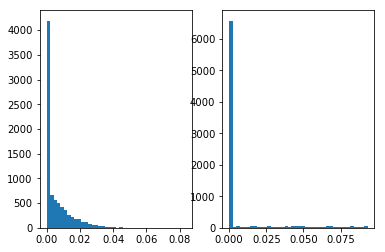

In [113]:
# TODO: in make_rnd_connectivity() change the uniform sampling of weigths for lognormal in order to get fewer large weigthd

logm result may be inaccurate, approximate err = 2.2934561931530673e-13
logm result may be inaccurate, approximate err = 1.0492687866484024e-11
logm result may be inaccurate, approximate err = 1.4126075931927757e-12


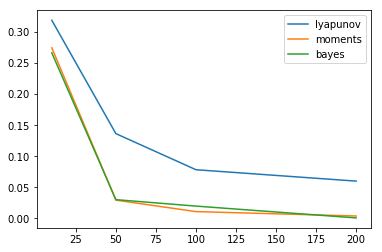

In [90]:
from make_rnd_connectivity import make_rnd_connectivity

Ms = [10, 50, 100, 200]
r_lya = np.zeros([len(Ms)])
r_mom = np.zeros([len(Ms)])
r_bay = np.zeros([len(Ms)])
for i, m in enumerate(Ms):
    C_true = make_rnd_connectivity(m, connectivity_strength=.4)
    model = MOU(n_nodes=m, C=C_true)
    ts_sim = model.simulate(T=300)
    model.fit(X=ts_sim, method='lyapunov')
    Clya = model.C
    model.fit(X=ts_sim, method='moments')
    Cmom = model.C
    model.fit(X=ts_sim, method='bayes')
    Cbay = model.C
    r_lya[i] = pearsonr(Clya.flatten(), C_true.flatten())[0]
    r_mom[i] = pearsonr(Cmom.flatten(), C_true.flatten())[0]
    r_bay[i] = pearsonr(Cbay.flatten(), C_true.flatten())[0]
plt.figure()
plt.plot(Ms, r_lya, label='lyapunov')
plt.plot(Ms, r_mom, label='moments')
plt.plot(Ms, r_bay, label='bayes')
plt.legend()
plt.show()

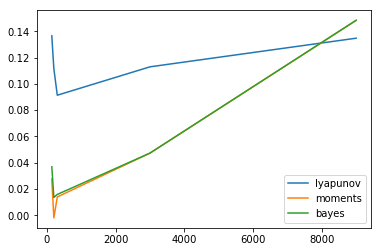

In [107]:
Ts = [140, 200, 300, 3000, 9000]
m = 50
r_lya = np.zeros([len(Ts)])
r_mom = np.zeros([len(Ts)])
r_bay = np.zeros([len(Ts)])
for i, t in enumerate(Ts):
    C_true = make_rnd_connectivity(m, connectivity_strength=.2)
    model = MOU(n_nodes=m, C=C_true)
    ts_sim = model.simulate(T=t)
    model.fit(X=ts_sim, method='lyapunov')
    Clya = model.C
    model.fit(X=ts_sim, method='moments')
    Cmom = model.C
    model.fit(X=ts_sim, method='bayes')
    Cbay = model.C
    r_lya[i] = pearsonr(Clya.flatten(), C_true.flatten())[0]
    r_mom[i] = pearsonr(Cmom.flatten(), C_true.flatten())[0]
    r_bay[i] = pearsonr(Cbay.flatten(), C_true.flatten())[0]
plt.figure()
plt.plot(Ts, r_lya, label='lyapunov')
plt.plot(Ts, r_mom, label='moments')
plt.plot(Ts, r_bay, label='bayes')
plt.legend()
plt.show()

In [104]:
model.C.shape

(50, 50)